In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st
sns.set()
np.random.seed(42)

## 1. Generate synthetic finance-like data

In [4]:
n = 240
dates = pd.bdate_range(start='2024-01-02', periods=n)

# Simulate factor returns
mkt_excess = np.random.normal(0, 0.01, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.008, size=n)
momentum = np.random.normal(0, 0.006, size=n)

# True coefficients
beta0 = 0.0002
beta_mkt = 0.8
beta_size = 0.3
beta_value = -0.2
beta_mom = 0.4
beta_mom2 = 4.0  # introduce a mild quadratic effect

# Heteroscedastic noise: scale increases with |market|
noise_scale = 0.004 + 0.6 * np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)

asset_excess = (
    beta0 + beta_mkt * mkt_excess + beta_size * size + beta_value * value + beta_mom * momentum
    + beta_mom2 * (momentum ** 2)
    + eps
)

df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-01-02,0.004967,-0.006340,-0.001023,0.001847,0.007715
1,2024-01-03,-0.001383,-0.000918,-0.007644,-0.010261,0.003083
2,2024-01-04,0.006477,0.004040,-0.012852,-0.008089,0.007740
3,2024-01-05,0.015230,0.006926,0.001628,0.004460,0.025315
4,2024-01-08,-0.002342,-0.009602,-0.006051,0.001025,-0.003415


In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,240,2024-06-16 21:36:00,2024-01-02 00:00:00,2024-03-25 18:00:00,2024-06-17 12:00:00,2024-09-09 06:00:00,2024-12-02 00:00:00,NaN
mkt_excess,240.0,-0.000024,-0.026197,-0.006855,0.000623,0.005931,0.038527,0.009708
size,240.0,0.000285,-0.02593,-0.005043,0.000091,0.005464,0.024631,0.00792
value,240.0,-0.000508,-0.021575,-0.006065,-0.000492,0.004771,0.020587,0.007996
momentum,240.0,0.000738,-0.013193,-0.003338,0.001046,0.00409,0.015794,0.005674
asset_excess,240.0,0.001643,-0.03165,-0.005768,0.001299,0.009222,0.050753,0.012698


## 2. Split into train/test (e.g., 80/20)

In [13]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## 3. Fit sklearn.linear_model.LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

## 4. Compute predictions, residuals, R², and RMSE

In [ ]:
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2, rmse

r2, rmse

(0.4003321117820219, np.float64(0.010904384530872818))

## 5. Plot residuals vs fitted, histogram, QQ; optionally residuals vs a key predictor and residual lag-1

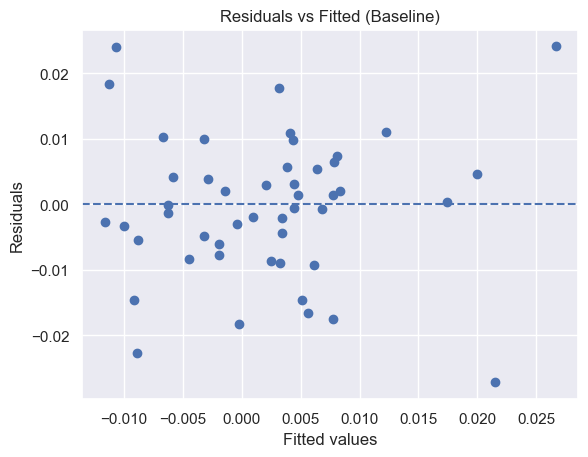

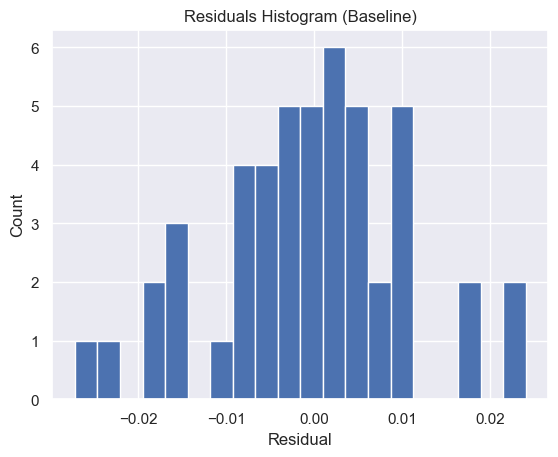

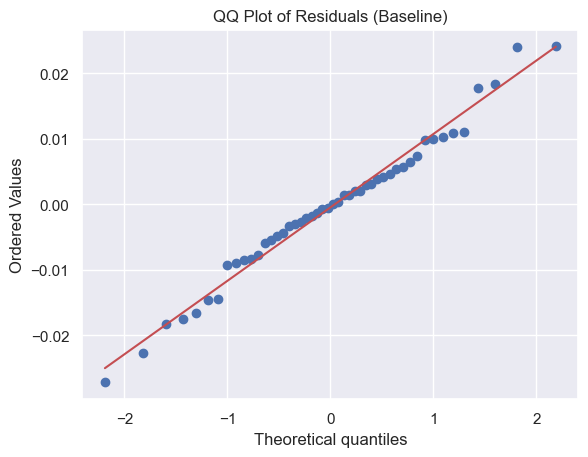

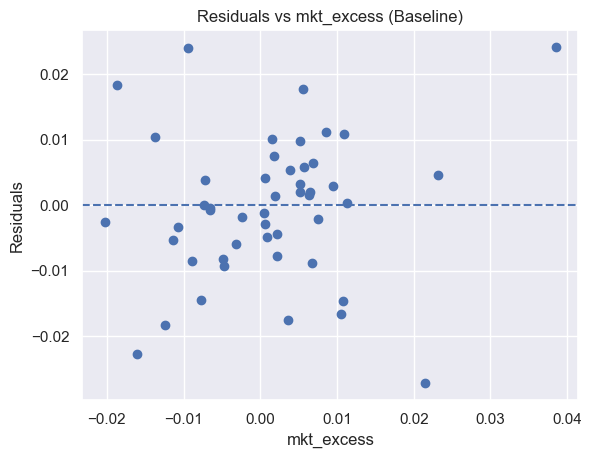

In [7]:
resid = y_test - y_pred
fitted = y_pred

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Fitted (Baseline)')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

plt.figure()
plt.hist(resid, bins=20)
plt.title('Residuals Histogram (Baseline)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.figure()
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals (Baseline)')
plt.show()

plt.figure()
plt.scatter(X_test['mkt_excess'], resid)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs mkt_excess (Baseline)')
plt.xlabel('mkt_excess')
plt.ylabel('Residuals')
plt.show()

## Interpreting each assumption
1. Linearity: residuals should have no structure when plotted versus fitted values or predictors.
2. Independence: residuals shouldn’t autocorrelate (a caveat in time series).
3. Homoscedasticity: constant residual variance; otherwise standard errors and inference distort.
4. Normality: residuals are normally distributed (important for small-sample inference; less crucial for
point prediction with large n).

## Regression Assumptions Diagnostic Cheat Sheet

| Assumption | Primary Diagnostic Plot | Secondary Diagnostic Plot | What to Look For |
|------------|-------------------------|---------------------------|------------------|
| **Linearity** | Residuals vs Fitted | – | Random scatter around 0 → linearity satisfied. Curvature → non-linearity. |
| **Homoscedasticity (constant variance)** | Scale-Location | Residuals vs Fitted | Funnel shape or systematic trend → heteroscedasticity. Horizontal spread → constant variance. |
| **Normality of errors** | Q-Q Plot | Histogram of Residuals | Points on 45° line → normal residuals. Deviations at ends → non-normality. Histogram bell-shaped → normal; skew/multimodal → non-normal. |
| **Independence / no autocorrelation** | Residual Autocorrelation (ACF) | Residuals vs Observation | Spikes outside confidence bands → dependence. Random small spikes → independent. Residual scatter random → independence; visible patterns → autocorrelation. |

**Notes:**
- `Residuals vs Fitted` can help detect both linearity and heteroscedasticity.  
- `Scale-Location` emphasizes non-constant variance more clearly.  
- Q-Q plot focuses purely on the distribution of residuals.  
- Residual ACF highlights dependence between observations.  


In [8]:
def fit_ols(x, y):
    """Fits OLS regression and returns model and predicted values."""
    X_const = sm.add_constant(x)
    model = sm.OLS(y, X_const).fit()
    y_pred = model.predict(X_const)
    return model, y_pred

def plot_scatter_with_line(x, y, y_pred, r2, title="Scatter with Regression", xlabel="X", ylabel="Y"):
    """Plots scatter plot and regression line with R^2."""
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, label="Data")
    plt.plot(x, y_pred, color='red', label=f"Regression line\n$R^2={r2:.2f}$")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def scatter_with_regression(x, y, title="Scatter with Regression", xlabel="X", ylabel="Y"):
    model, y_pred = fit_ols(x, y)
    r2 = r2_score(y, y_pred)
    plot_scatter_with_line(x, y, y_pred, r2, title, xlabel, ylabel)
    return model
    
def scatter_with_regression_zoom(x, y, title="Scatter with Regression", 
                                 xlabel="X", ylabel="Y", zoom=(0,0)):
    """
    Fit OLS on full data, but optionally zoom in by removing extremes from plotting.
    zoom = (n_x, n_y) removes n_x extreme points from x and n_y from y (top or bottom)
    """
    # If x is a single-column DataFrame, convert to Series
    if isinstance(x, pd.DataFrame) and x.shape[1] == 1:
        x = x.iloc[:,0]
        
    # Fit full model
    model, y_pred = fit_ols(x, y)
    
    # Determine indices to keep
    idx_x = np.arange(len(x))
    idx_y = np.arange(len(y))
    
    if zoom[0] > 0:
        # Remove n_x most extreme x values (top or bottom)
        sorted_x_idx = np.argsort(x)
        idx_x = sorted_x_idx[zoom[0]:-zoom[0]] if zoom[0]*2 < len(x) else sorted_x_idx
    if zoom[1] > 0:
        # Remove n_y most extreme y values (top or bottom)
        sorted_y_idx = np.argsort(y)
        idx_y = sorted_y_idx[zoom[1]:-zoom[1]] if zoom[1]*2 < len(y) else sorted_y_idx
    
    # Intersection of indices to keep
    keep_idx = np.intersect1d(idx_x, idx_y)
    
    # Filter for plotting only
    x_plot = x.iloc[keep_idx] if isinstance(x, pd.Series) else x[keep_idx]
    y_plot = y.iloc[keep_idx] if isinstance(y, pd.Series) else y[keep_idx]
    y_pred_plot = y_pred[keep_idx]
    
    # Plot
    r2 = r2_score(y, y_pred)
    plot_scatter_with_line(x_plot, y_plot, y_pred_plot, r2, title=title, xlabel=xlabel, ylabel=ylabel)
    
    return model

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score

np.random.seed(42)

In [12]:
def scatter_two_predictors_side_by_side_with_predictions(X, y, predictor1, predictor2):
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    
    for i, col in enumerate([predictor1, predictor2]):
        x = X[col]
        X_const = sm.add_constant(X)
        model = sm.OLS(y, X_const).fit()
        y_pred = model.predict(X_const)
        r2 = r2_score(y, y_pred)
        
        # Plot scatter and regression line
        sorted_idx = x.argsort()
        x_sorted = x.iloc[sorted_idx]
        y_pred_sorted = y_pred.iloc[sorted_idx]
        axes[i].scatter(x, y, label="Data", alpha=0.6)
        axes[i].plot(x_sorted, y_pred_sorted, color='red', label=f"Regression line\n$R^2={r2:.2f}$")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Y")
        axes[i].set_title(f"{col} vs Y (full model regression)")
        axes[i].legend()
    
    # Plot predicted vs observed Y
    y_pred_full = sm.OLS(y, sm.add_constant(X)).fit().predict(sm.add_constant(X))
    axes[2].scatter(y, y_pred_full, color='green', alpha=0.6, label="Predicted vs Observed")
    axes[2].plot([y.min(), y.max()], [y.min(), y.max()], color='black', linestyle='--', label='Perfect prediction')
    axes[2].set_xlabel("Observed Y")
    axes[2].set_ylabel("Predicted Y")
    axes[2].set_title("Predicted vs Observed Y")
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
## Conclude: state whether you trust this model and why.